In [1]:
# First install takes a while to download models
!pip install --quiet -r requirements.txt

In [18]:
import os
import random
import re

import graphistry
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import seaborn as sns

In [3]:
# Environment variable setup
GRAPHISTRY_USERNAME = os.getenv("GRAPHISTRY_USERNAME")
GRAPHISTRY_PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")

# Part 2: Quantitative Networks: Social Network Analysis and Network Science

## Visualizing Networks with Graphistry

Throughout this part of the course we will be using `pygraphistry` and [Graphistry Hub](https://hub.graphistry.com/) [https://hub.graphistry.com/](https://hub.graphistry.com/) to visualize networks. Both are free for personal use and are powerful for visualizing networks large and small.

You can [signup](https://hub.graphistry.com/accounts/signup/) for a Graphistry account at [https://hub.graphistry.com/accounts/signup/](https://hub.graphistry.com/accounts/signup/) with your Github or Google account. Retain and use the username and password in 

In [4]:
graphistry.register(
    api=3,
    username=GRAPHISTRY_USERNAME,
    password=GRAPHISTRY_PASSWORD,
)

# Network Science on Citation Networks

We start with an example of a citation network: [High-energy physics theory citation network](https://snap.stanford.edu/data/cit-HepTh.html) from [Stanford SNAP](http://snap.stanford.edu/). A citation network describes how one academic paper cites another one.

> Arxiv HEP-TH (high energy physics theory) citation graph is from the e-print arXiv and covers all the citations within a dataset of 27,770 papers with 352,807 edges. If a paper i cites paper j, the graph contains a directed edge from i to j. If a paper cites, or is cited by, a paper outside the dataset, the graph does not contain any information about this.
>
> The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv, and thus represents essentially the complete history of its HEP-TH section.
>
> The data was originally released as a part of [2003 KDD Cup](http://www.cs.cornell.edu/projects/kddcup/).

J. Leskovec, J. Kleinberg and C. Faloutsos. [Graphs over Time: Densification Laws, Shrinking Diameters and Possible Explanations.](http://www.cs.cmu.edu/~jure/pubs/powergrowth-kdd05.pdf) ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2005.

Note: in addition to the metadata in the graph below, the time of paper submission is also available: https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz

## Extract Edge List and Build Directional Graph (DiGraph)

First we download the edge list and build the structure of the network: `(paper)-cited->(paper)`

In [5]:
import gzip
import io
import networkx as nx
import tarfile


# Initialize a directed graph
G = nx.DiGraph()

# Download and load edges (citations) from `cit-HepTh.txt.gz`
response = requests.get("https://snap.stanford.edu/data/cit-HepTh.txt.gz")
gzip_content = io.BytesIO(response.content)

# Decompress the gzip content and build the edge list for our network
with gzip.GzipFile(fileobj=gzip_content) as f:
    for line in f:
        line = line.decode('utf-8')
        # Ignore lines that start with '#'
        if not line.startswith('#'):
            cited, citing = line.strip().split('\t')
            G.add_edge(citing, cited)

## Summarize the Propertis of our DiGraph

Let's check how many nodes and edges we have. This will help evaluate how we are doing when we parse the abstracts to add properties to our DiGraph.

In [6]:
print(f"Total nodes: {G.number_of_nodes():,}")
print(f"Total edges: {G.number_of_edges():,}")

Total nodes: 27,770
Total edges: 352,807


## Add Properties to Nodes in Network

Now we will use `extract_paper_info(text)` to add structured data to the nodes in our network.

### Using ChatGPT to Write NetworkX Code

We cover Chatbots at the end of this course, I just want to point out that the following dialogue generated the basis for the code below.

```
I am going to past some text representing some semi-structured data about an academic paper below:

Paper: hep-th/0002031
From: Maulik K. Parikh 
Date: Fri, 4 Feb 2000 17:04:51 GMT   (10kb)

Title: Confinement and the AdS/CFT Correspondence
Authors: D. S. Berman and Maulik K. Parikh
Comments: 12 pages, 1 figure, RevTeX
Report-no: SPIN-1999/25, UG-1999/42
Journal-ref: Phys.Lett. B483 (2000) 271-276
\\
  We study the thermodynamics of the confined and unconfined phases of
superconformal Yang-Mills in finite volume and at large N using the AdS/CFT
correspondence. We discuss the necessary conditions for a smooth phase
crossover and obtain an N-dependent curve for the phase boundary.
\\

Now I want you to write python code to extract the fields "Paper", "From", "Date", "Title", "Authors", "Comments", "Report-no", "Journal-ref" and the last field the "Abstract" text content.
```

One cycle of correction looked like:

```
That code did not work on this record:

------------------------------------------------------------------------------
\\
Paper: hep-th/9711200
From: Juan Maldacena <malda@physics.rutgers.edu>
Date: Thu, 27 Nov 1997 23:53:13 GMT   (22kb)
Date (revised v2): Mon, 8 Dec 1997 18:59:11 GMT   (23kb)
Date (revised v3): Thu, 22 Jan 1998 15:42:41 GMT   (23kb)

Title: The Large N Limit of Superconformal Field Theories and Supergravity
Authors: Juan M. Maldacena
Comments: 20 pages, harvmac, v2: section on AdS_2 corrected, references added,
  v3: More references and a sign in eqns 2.8 and 2.9 corrected
Report-no: HUTP-98/A097
Journal-ref: Adv.Theor.Math.Phys. 2 (1998) 231-252; Int.J.Theor.Phys. 38 (1999)
  1113-1133
\\
  We show that the large $N$ limit of certain conformal field theories in
various dimensions include in their Hilbert space a sector describing
supergravity on the product of Anti-deSitter spacetimes, spheres and other
compact manifolds. This is shown by taking some branes in the full M/string
theory and then taking a low energy limit where the field theory on the brane
decouples from the bulk. We observe that, in this limit, we can still trust the
near horizon geometry for large $N$. The enhanced supersymmetries of the near
horizon geometry correspond to the extra supersymmetry generators present in
the superconformal group (as opposed to just the super-Poincare group). The 't
Hooft limit of 4-d ${\cal N} =4$ super-Yang-Mills at the conformal point is
shown to contain strings: they are IIB strings. We conjecture that
compactifications of M/string theory on various Anti-deSitter spacetimes are
dual to various conformal field theories. This leads to a new proposal for a
definition of M-theory which could be extended to include five non-compact
dimensions.
\\

It should have started the Abstract extraction with "We show that" but instead it includes the entire document. Please fix.
```

There were a few more iterations, so this is not "free." I then had to edit the code and that is what is in the cell. ChatGPT is your running mate :)

In [7]:
def extract_paper_info(record):
    """Extract structured information from the text of academic paper text records using regular expressions.
       
       Note: I was written wholly or in part by ChatGPT4 on May 23, 2023.
    """
    
    # Initialize an empty dictionary to hold the information
    info = {}
    
    # Match "Paper" field
    paper_match = re.search(r"Paper:\s*(.*)", record)
    if paper_match:
        info['Paper'] = paper_match.group(1)
        
    # Match "From" field
    from_match = re.search(r"From:\s*(.*)", record)
    if from_match:
        info['From'] = from_match.group(1)
    
    # Match "Date" field
    date_match = re.search(r"Date:\s*(.*)", record)
    if date_match:
        info['Date'] = date_match.group(1)
    
    # Match "Title" field
    title_match = re.search(r"Title:\s*(.*)", record)
    if title_match:
        info['Title'] = title_match.group(1)

    # Match "Authors" field
    authors_match = re.search(r"Authors:\s*(.*)", record)
    if authors_match:
        info['Authors'] = authors_match.group(1)

    # Match "Comments" field
    comments_match = re.search(r"Comments:\s*(.*)", record)
    if comments_match:
        info['Comments'] = comments_match.group(1)

    # Match "Report-no" field
    report_no_match = re.search(r"Report-no:\s*(.*)", record)
    if report_no_match:
        info['Report-no'] = report_no_match.group(1)

    # Match "Journal-ref" field
    journal_ref_match = re.search(r"Journal-ref:\s*(.*)", record)
    if journal_ref_match:
        info['Journal-ref'] = journal_ref_match.group(1)

    # Extract "Abstract" field
    abstract_pattern = r"Journal-ref:[^\\\\]*\\\\[\n\s]*(.*?)(?=\\\\)"
    abstract_match = re.search(abstract_pattern, record, re.DOTALL)
    if abstract_match:
        abstract = abstract_match.group(1)
        abstract = abstract.replace('\n', ' ').replace('  ', ' ')
        info['Abstract'] = abstract.strip()

    return info

In [8]:
# Download the abstracts from `cit-HepTh-abstracts.tar.gz`
abstract_response = requests.get("https://snap.stanford.edu/data/cit-HepTh-abstracts.tar.gz")

# Convert the response content to an in-memory binary stream
abstract_gzip_content = io.BytesIO(abstract_response.content)

# Decompress the gzip content
with gzip.GzipFile(fileobj=abstract_gzip_content) as f:
    with tarfile.open(fileobj=f, mode='r|') as tar:
        for member in tar:
            abstract_file = tar.extractfile(member)
            if abstract_file is not None:
                content = abstract_file.read().decode('utf-8')
                paper_info = extract_paper_info(content)
                if paper_info:
                    paper_id = paper_info.get("Paper", "").split("/")[-1]  # Get the paper ID part of the "Paper" field
                    if paper_id in G:
                        for field, value in paper_info.items():
                            if paper_id in G:
                                G.nodes[paper_id][field] = value
                    else:
                        G.add_node(paper_id, **paper_info)

# Now `G` is a property graph representing the "High-energy physics theory citation network" dataset

In [9]:
G.nodes["9711194"]

{'Paper': 'hep-th/9711194',
 'From': 'ess@vitep5.itep.ru',
 'Date': 'Wed, 26 Nov 1997 20:26:20 GMT   (5kb)',
 'Title': 'On Integrable Structure behind the Generalized WDVV Equations',
 'Comments': 'LaTeX, 6pp',
 'Report-no': 'ITEP/TH-67/97',
 'Journal-ref': 'Phys.Lett. B427 (1998) 93-96',
 'Abstract': 'In the theory of quantum cohomologies the WDVV equations imply integrability of the system $(I\\partial_\\mu - zC_\\mu)\\psi = 0$. However, in generic situation -- of which an example is provided by the Seiberg-Witten theory -- there is no distinguished direction (like $t^0$) in the moduli space, and such equations for $\\psi$ appear inconsistent. Instead they are substituted by $(C_\\mu\\partial_\\nu - C_\\nu\\partial_\\mu)\\psi^{(\\mu)} \\sim (F_\\mu\\partial_\\nu - F_\\nu\\partial_\\mu)\\psi^{(\\mu)} = 0$, where matrices $(F_\\mu)_{\\alpha\\beta} = \\partial_\\alpha \\partial_\\beta \\partial_\\mu F$.'}

## Describing our Citation Network `nx.DiGraph`

Now we can check a few theoretical properties of our DiGraph. I'll frame it in terms of questions and metrics.

* Domain question: How many citations does each paper have across the entire network?
* Metric 1: What is the average degree, in-degree and out-degree of the network?

In [10]:
# Extract degree, in-degree, and out-degree for each node
# +1 is to avoid problems with log-scale display
degree_sequence = [d + 1 for n, d in G.degree()]
in_degree_sequence = [d + 1 for n, d in G.in_degree()]
out_degree_sequence = [d + 1 for n, d in G.out_degree()]

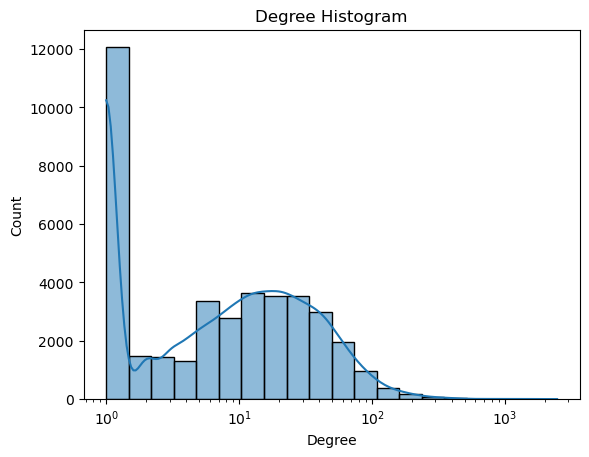

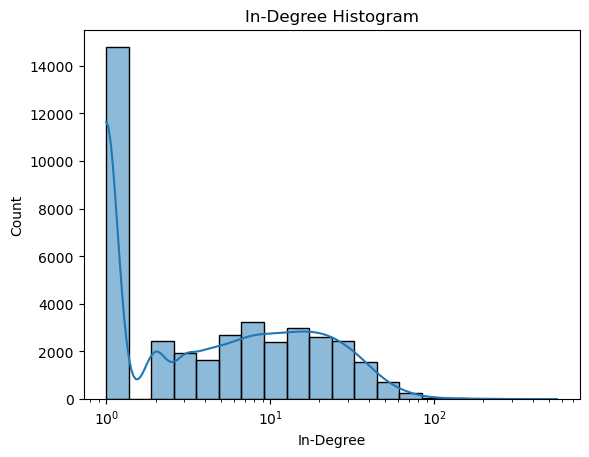

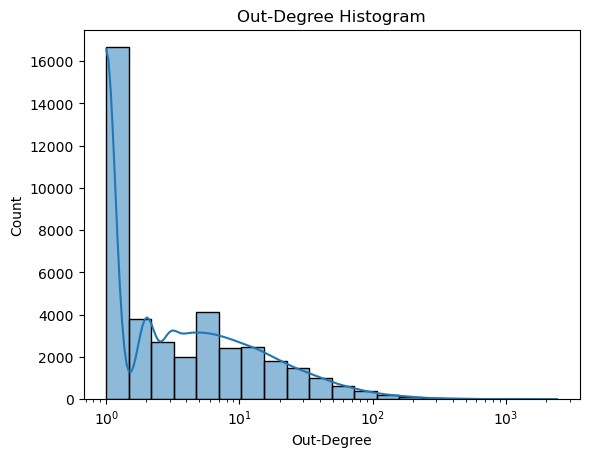

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histogram of degree
ax = sns.histplot(degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='Degree')
plt.title('Degree Histogram')
plt.show()

# Create histogram of in-degree
ax = sns.histplot(in_degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='In-Degree')
plt.title('In-Degree Histogram')
plt.show()

# Create histogram of out-degree
ax = sns.histplot(out_degree_sequence, bins=20, kde=True, log_scale=True)
ax.set(xlabel='Out-Degree')
plt.title('Out-Degree Histogram')
plt.show()

## Fitting a Random Graph Model to our Network

These degree histograms don't exist in a vacuum. They can be compared to theoretical models of networks to help interpret them. We mean to learn about our network, not simply compute metrics.

NetworkX has many random graph models in the form of [Graph Generators](https://networkx.org/documentation/stable/reference/generators.html) that can generate instances of a random graph. For small graphs, it is neccessary to iteratively generate and measure multiple instances of random graphs. For larger graphs a single instance can work. This is due to the 

### Erdos Reyni Graphs

We begin with a random graph model often used as a baseline, not because it fits real-world networks.

> An Erdős–Rényi (ER) graph is a simple model of a random graph. This model is named after Paul Erdős and Alfréd Rényi, who first introduced one version of it.
>
> In the ER model, a graph is constructed by connecting nodes randomly. Each edge is included in the graph with probability p, independent of the other edges. Thus, the model has two parameters: the number of nodes n, and the edge probability p.
>
> The ER model can be used to generate either a G(n, M) graph or a G(n, p) graph.
>
> In the G(n, M) model, a graph is chosen uniformly at random from the collection of all graphs with n nodes and M edges.
> In the G(n, p) model, a graph is constructed by connecting nodes randomly where each possible edge occurs independently with probability p.
> The ER model is a simple model that does not capture many of the properties of real-world networks, such as their community structure and degree distribution. However, it is useful in network theory because of its analytical tractability and because it serves as a null model against which the properties of real-world networks can be compared.

-- ChatGPT, verified by Russell Jurney

In [12]:
# Calculate the edge probability parameter for the Erdos-Renyi model
p = nx.density(G)
print(f"Network density: {p:.5f}")

# Create an Erdos-Renyi graph with the same number of nodes and the calculated edge probability
G_er = nx.erdos_renyi_graph(G.number_of_nodes(), p)

Network density: 0.00022


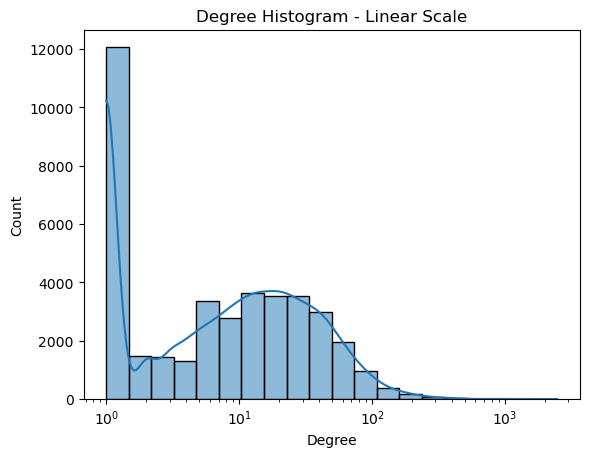

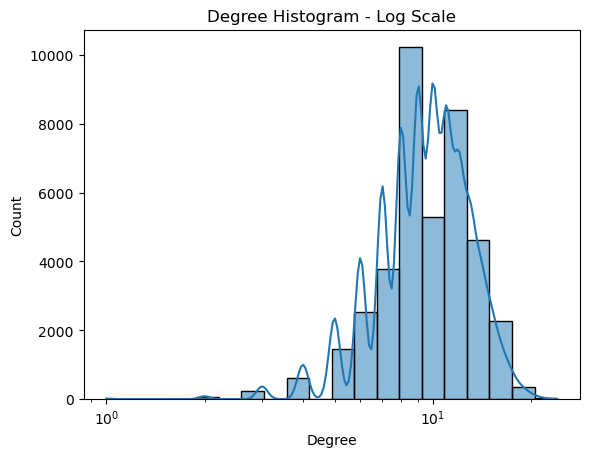

In [19]:
def plot_degree(G, G_compare):
    """Compute the degrees of a graph and them in linear and log scale."""
    degree_sequence = [d + 1 for n, d in G.degree()]

    # Create histogram of degree
    ax = sns.histplot(degree_sequence, bins=20, kde=True, log_scale=True)
    ax.set(xlabel='Degree')
    plt.title(f"Degree Histogram - Linear Scale")
    plt.show()

    compare_degree_sequence = [d + 1 for n, d in G_compare.degree()]

    # Create histogram of degree
    ax = sns.histplot(compare_degree_sequence, bins=20, kde=True, log_scale=True)
    ax.set(xlabel='Degree')
    plt.title(f"Degree Histogram - Log Scale")
    plt.show()

plot_degree(G, G_er)

### Barabasi-Albert Model

> Barabási-Albert Model (Preferential Attachment Model, Scale Free Network): This model generates a random graph where nodes are added to the network one at a time, and each new node attaches to existing nodes with a probability proportional to their degree.

A scale free network is one where its degree distribution fits a power law. In log scale, they proceed from top-left to bottom-right. Barabasi-Albert networks model step-wise growth of networks where edges are added in a way that prefers nodes with a higher degree.

--ChatGPT, extended by Russell Jurney

In [20]:
# Number of iterations required (This should be smaller than the total number of nodes)
n = G.number_of_nodes()

# Number of edges to attach from a new node to existing nodes
m = G.number_of_edges() // n

print(f"n: {n:,} m: {m:,}")

# Create a Barabasi-Albert graph with the same number of nodes and edges as the real graph
G_ba = nx.barabasi_albert_graph(n, m)

n: 39,840 m: 8


In [21]:
print(f"Total nodes: {G_ba.number_of_nodes():,}")

Total nodes: 39,840


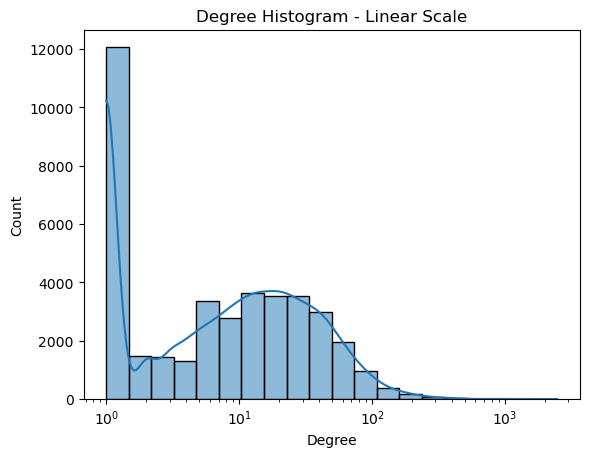

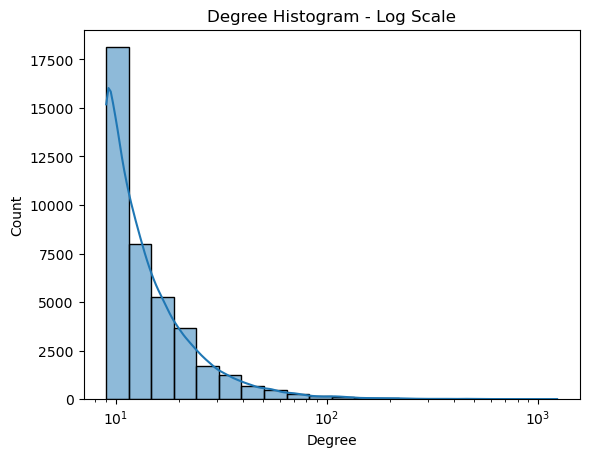

In [22]:
plot_degree(G, G_ba)

In [23]:
def citation_graph(n, m):
    """
    Create a citation graph with n nodes. Each new node attaches to m existing nodes.
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(2 * m))  # Start with 2m nodes
    G.add_edges_from((i, 2 * m) for i in range(2 * m))  # Each of the first 2m nodes links to the node 2m

    for i in range(2 * m + 1, n):
        # A new paper cites m existing papers. The probability of citing an existing paper is proportional to its in-degree.
        nodes = list(G.nodes())
        probabilities = [G.in_degree(n) for n in nodes]
        cited_nodes = random.choices(nodes, probabilities, k=m)
        for node in cited_nodes:
            G.add_edge(node, i)

    return G

In [ ]:
n = G.number_of_nodes()
m = (G.number_of_edges() // n)

G_cite = citation_graph(n, m)
plot_degrees(G, G_cite)

## Centrality Metrics

Next question: What are the most important papers in the field of physics during this period, from 1992 to 2003?
Metrics: Network centralities.

- Degree Centrality: 
- Eigenvector Centrality: 
- Closeness Centrality: 
- Betweenness Centrality: 
- Many others...

### Visualizing Centralities in Graphistry

In [ ]:
graphistry.bind(source='src', destination='dst', node='nodeid').plot(G)